In [1]:
#compare the analytical 21cm/CO auto power spectrum and the cross power spectrum with simulations
import numpy as np
import time
import sys
import os
import matplotlib 
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import special
import antisym_func
from importlib import reload

In [2]:
#calculate the Pk_A for certain models at input redshift array
def read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE):
    #read in the normalized zeta
    DIR_zeta = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/normalized_zeta.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_zeta): 
        data = np.load(DIR_zeta)
        z_zeta_interp_array = data['z']; zeta_z_interp_array = data['zeta_z']
        zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_zeta); sys.exit()
        
    #read in the history of HI fraction and dx_HI/dz
    DIR_history = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/history.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_history):
        data = np.load(DIR_history)
        z_array_history = list(data['z_array_history']); HI_history = list(data['HI_history'])
        z_dxHdz_history = list(data['z_dxHdz_history']); dxHdz_history = list(data['dxHdz_history'])
    else:
        print('file %s not found'%DIR_history); sys.exit()
    
    #read in the average density of the neutral region
    DIR_rhoHI = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/rhoHI_over_rho0.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_rhoHI):
        data = np.load(DIR_rhoHI)
        z_array_HIrho = list(data['z_array_HIrho']); rhoHI_over_rho0_array = list(data['rhoHI_over_rho0_array'])
        HIrho_over_rho0_interp = interp1d(z_array_HIrho, rhoHI_over_rho0_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_rhoHI); sys.exit()
    
    #load in the Bubble mass functions
    DIR_BMF = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/BMF_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_BMF):
        data = np.load(DIR_BMF)
        z_grid = list(data['z_grid']); m_grid = list(data['m_grid']); BMF_map = list(data['BMF_map'])       
        BMF_interp = interp2d(m_grid, z_grid, BMF_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_BMF); sys.exit()
    
    #load in the unsmoothed antisymmetric cross-correlation data
    DIR_xiHICO = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/xi_A_HICO_unsmoothed_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_xiHICO):
        data = np.load(DIR_xiHICO)
        z_grid = list(data['z_grid']); r12_grid = list(data['r12_grid']); xi_A_HICO_map = list(data['xi_A_HICO_map'])       
        xi_A_HICO_unsmoothed_interp = interp2d(r12_grid, z_grid, xi_A_HICO_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_xiHICO); sys.exit()
    return zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
            BMF_interp, xi_A_HICO_unsmoothed_interp

In [3]:
#set the paramters and compute the history
zeta = 25; T_vir = 3e4; R_mfp = 50; SMOOTHING_SCALE = 384
mu = 1.22 if T_vir < 9.99999e3 else 0.6
M_max = antisym_func.RtoM(R_mfp)

#read in the fiducial model
DIR = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/xi_A_HICO'
zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
BMF_func, xi_A_HICO_unsmoothed_interp = read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE)

In [144]:
#read in the simulation result of Tan
file = open('../data/Tan/paz_7.67_384Mpc.txt').read()
#k in h / Mpc, power spectrums in muK^2 (Mpc/h)**3
k_Tan = []; anti_Tan = []; var_anti_Tan = []; sym_Tan = []
N_Tan = []; P_21_Tan =[]; P_co_Tan = []
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t')
        k_Tan.append(float(i[0])); anti_Tan.append(float(i[1])); sym_Tan.append(float(i[3])) #var_anti.append(i[2])
        P_21_Tan.append(float(i[5])); P_co_Tan.append(float(i[6])) #N.append(i[4])

#read in the simulation result of the lightcone box
k_simu = []; sym_simu = []; P_21_simu =[]; P_co_simu = []
file = open('../data/antisym_observability/21cmFAST/P21_LC.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t') 
        k_simu.append(float(i[0])); # Mpc^-1
        P_21_simu.append(float(i[1])) # mK^2 Mpc^-3
k_simu = np.array(k_simu) / antisym_func.hlittle # in the unit of h / Mpc     
P_21_simu = np.array(P_21_simu) * 1e6 * antisym_func.hlittle**3 #in the unit of muK^2 h^-3 Mpc^3

file = open('../data/antisym_observability/21cmFAST/PCO_LC.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t')
        P_co_simu.append(float(i[1])) # muK^2 Mpc^-3
P_co_simu = np.array(P_co_simu) * antisym_func.hlittle**3 #in the unit of muK^2 h^-3 Mpc^3
    
file = open('../data/antisym_observability/21cmFAST/Psym_LC.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t')
        sym_simu.append(float(i[1]))  # muK * mK * Mpc^-3
sym_simu = np.array(sym_simu) * 1e3 * antisym_func.hlittle**3 #in the unit of muK^2 h^-3 Mpc^3
        
#read in the simulation result of the static box
k_simu_static = []; sym_simu_static = []; P_21_simu_static =[]; P_co_simu_static = []
file = open('../data/antisym_observability/21cmFAST/P21_384Mpc.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t') 
        k_simu_static.append(float(i[0])); # Mpc^-1
        P_21_simu_static.append(float(i[1])) # mK^2 Mpc^-3

file = open('../data/antisym_observability/21cmFAST/PCO_384Mpc.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t')
        P_co_simu_static.append(float(i[1])) # muK^2 Mpc^-3
file = open('../data/antisym_observability/21cmFAST/P_cross_384Mpc.txt').read()
for i in file.split('\n'):
    if i == '': break
    if '#' in i: continue
    else:
        i = i.split('\t')
        sym_simu_static.append(float(i[1]))  # muK * mK * Mpc^-3

In [111]:
reload(antisym_func)
#compute the power spectrums
z = 7.67
P_CO_ana = []; P_21_ana = []; sym_ana = []; anti_ana = []

#compute the symmetric cross-correlation and the 21cm anto power spectrum
r12_limit = 150; r12_grid = np.zeros(100); r12_grid[0:30] = np.linspace(0.1, 5, 30)
r12_grid[30:100] = np.linspace(5, r12_limit, 71)[1:71]
xi_S_HICO_array = []; xi_auto_21_array = []; xi_A_HICO_smoothing_array = []; xi_A_HICO_smoothed_array = []
for r12 in r12_grid:
    xi_S_HICO_array.append(antisym_func.xi_S_HICO(z, r12, zeta_z_func, HIrho_over_rho0_interp, lambda m: BMF_func(m, z), M_max, T_vir, mu))
    xi_auto_21_array.append(antisym_func.xi_auto_21(z, r12, zeta_z_func, HIrho_over_rho0_interp, lambda m: BMF_func(m, z), M_max, T_vir, mu))
    xi_A_HICO_smoothed_array.append(antisym_func.xi_A_HICO_smoothing(z, r12, xi_A_HICO_unsmoothed_interp, SMOOTHING_SCALE)[0])
xi_S_HICO_func = interp1d(r12_grid, xi_S_HICO_array, kind = 'cubic')
xi_auto_21_func = interp1d(r12_grid, xi_auto_21_array, kind = 'cubic')
xi_A_HICO_smoothed_func = interp1d(r12_grid, xi_A_HICO_smoothed_array, kind = 'cubic')

for kh in k_Tan:
    k = kh * antisym_func.hlittle
    P_CO_ana.append(antisym_func.Pk_auto_CO(z, k, T_vir, mu))
    sym_ana.append(antisym_func.Pk_S(k, xi_S_HICO_func, min(r12_grid), max(r12_grid)))
    P_21_ana.append(antisym_func.Pk_S(k, xi_auto_21_func, min(r12_grid), max(r12_grid)))
    anti_ana.append(antisym_func.Pk_A_cal(k, xi_A_HICO_smoothed_func, min(r12_grid), max(r12_grid)))

/Users/liuzhaoning/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/liuzhaoning/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


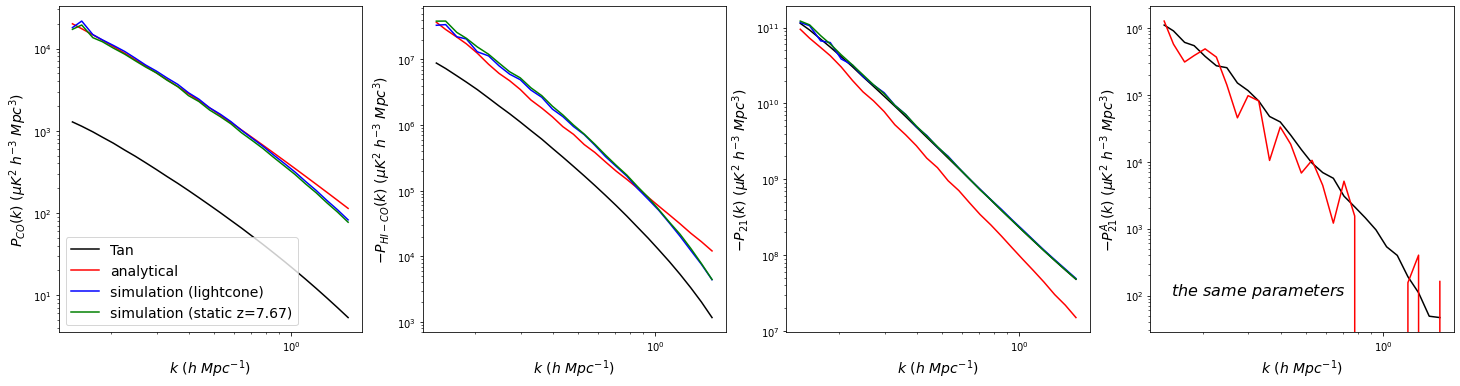

In [159]:
fig, axs = plt.subplots(1, 4, figsize=(25, 6))
axs[0].loglog(k_Tan, P_co_Tan, label= 'Tan', color = 'black')
axs[0].loglog(k_Tan, P_CO_ana, label = 'analytical', color = 'red')
axs[0].loglog(np.array(k_simu[1:]) / antisym_func.hlittle, np.array(P_co_simu[1:]) * antisym_func.hlittle**3, label = 'simulation (lightcone)', color = 'blue')
axs[0].loglog(np.array(k_simu_static[1:]) / antisym_func.hlittle, np.array(P_co_simu_static[1:]) * antisym_func.hlittle**3, label = 'simulation (static z=7.67)', color = 'green')
axs[0].legend(fontsize=14, loc=3)
axs[0].set_xlabel(r'$k\ (h\ Mpc^{-1})$',fontsize=14)
axs[0].set_ylabel(r'$P_{CO}(k)\ (\mu K^2\ h^{-3}\ Mpc^3)$',fontsize=14)

axs[1].loglog(k_Tan, -np.array(sym_Tan), label= 'Tan', color = 'black')
axs[1].loglog(k_Tan, -np.array(sym_ana), label = 'analytical', color = 'red')
axs[1].loglog(np.array(k_simu[1:]) / antisym_func.hlittle, -np.array(sym_simu[1:]) * 1e3 * antisym_func.hlittle**3, label = 'simulation', color = 'blue')
axs[1].loglog(np.array(k_simu_static[1:]) / antisym_func.hlittle, -np.array(sym_simu_static[1:]) * 1e3 * antisym_func.hlittle**3, label = 'simulation (static z=7.67)', color = 'green')
axs[1].set_xlabel(r'$k\ (h\ Mpc^{-1})$',fontsize=14)
axs[1].set_ylabel(r'$-P_{HI-CO}(k)\ (\mu K^2\ h^{-3}\ Mpc^3)$',fontsize=14)

axs[2].loglog(k_Tan, np.array(P_21_Tan), label= 'Tan', color = 'black')
axs[2].loglog(k_Tan, np.array(P_21_ana), label = 'analytical', color = 'red')
axs[2].loglog(np.array(k_simu[1:]) / antisym_func.hlittle, np.array(P_21_simu[1:]) * 1e6 * antisym_func.hlittle**3, label = 'simulation', color = 'blue')
axs[2].loglog(np.array(k_simu_static[1:]) / antisym_func.hlittle, np.array(P_21_simu_static[1:]) * 1e6 * antisym_func.hlittle**3, label = 'simulation (static z=7.67)', color = 'green')
axs[2].set_xlabel(r'$k\ (h\ Mpc^{-1})$',fontsize=14)
axs[2].set_ylabel(r'$-P_{21}(k)\ (\mu K^2\ h^{-3}\ Mpc^3)$',fontsize=14)

axs[3].loglog(k_Tan, -np.array(anti_Tan), label= 'Tan', color = 'black')
axs[3].loglog(k_Tan, np.array(anti_ana), label = 'analytical', color = 'red')
axs[3].set_xlabel(r'$k\ (h\ Mpc^{-1})$',fontsize=14)
axs[3].set_ylabel(r'$-P^A_{21}(k)\ (\mu K^2\ h^{-3}\ Mpc^3)$',fontsize=14)
axs[3].text(0.15, 1e2 ,r'$the\ same\ parameters$', fontsize=16)
plt.savefig('../figures/power_spectrums_examination.png', bbox_inches='tight', dpi=200)
plt.show()
#Tan is the data from Zhou in 2018
#simulation is the simulation result by Zhou's code
#analytical is my analytical result from antisym_func.py